# NLP Basic Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [121]:
# 필요한 모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
os.chdir('C:/Users/cts08/Tobigs19_work')

## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [122]:
spam = pd.read_csv('spam.csv')

In [123]:
spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [124]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [125]:
spam.isnull().value_counts()

v1     v2   
False  False    5572
dtype: int64

In [126]:
spam['v2'].nunique()

5169

spam 데이터에 대해 설명해보도록 한다.

* 2개 열, 5572개 데이터
* v1 = 스팸 분류 여부(ham, spam), v2 = 문장
* 결측치가 존재하지 않음.
* v2 열의 문장들에 대해 중복값이 존재함. 총 5572개의 데이터에서 중복을 제외한 샘플의 수는 5168개.

따라서 중복 샘플들을 제거해준다.

In [127]:
spam.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(spam))

총 샘플의 수 : 5169


In [128]:
spam['v1'].value_counts()[0]

4516

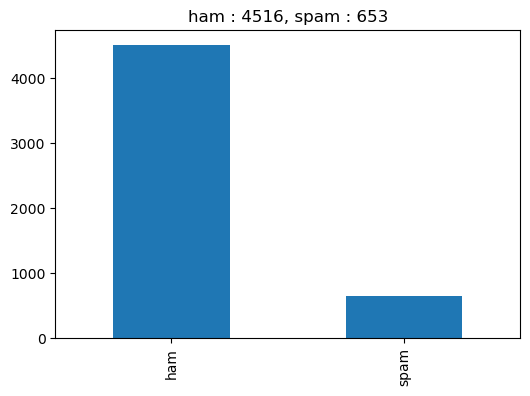

In [129]:
plt.figure(figsize = (6,4))
spam['v1'].value_counts().plot(kind='bar')
plt.title('ham : {0}, spam : {1}'.format(spam['v1'].value_counts()[0], spam['v1'].value_counts()[1]))
plt.show()

위의 그래프는 spam 데이터와 ham(spam이 아닌) 데이터의 분포를 나타낸 그래프이다. 중복 샘플을 제거한 5168개의 샘플에 대해서 스팸이 아닌 데이터는 4516개, 스팸인 데이터는 652개로 데이터 불균형이 일어남을 알 수 있다. 따라서 차후에 모델을 만드는데 있어서 훈련 데이터와 테스트 데이터에 고르게 분포되도록 하는 것이 중요하다. 이는 sklearn의 stratify 인자를 통해 가능하다.

간단하게 spam 데이터와 spam이 아닌 데이터의 분포를 알아보도록 한다.

## Tokenizing


### 특수문자 제거

In [130]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

위의 문장 예시를 보면 !, ? 등과 같이 문장 내 특수문자가 존재함을 알 수 있다. 따라서 이를 정규방정식을 통해 제거해줄 필요가 있다.

In [133]:
import re

spam['v2'] = [re.sub('[^A-Za-z]', ' ', s).lower() for s in spam['v2']]

spam.iloc[5]['v2']

'freemsg hey there darling it s been   week s now and no word back  i d like some fun you up for it still  tb ok  xxx std chgs to send         to rcv'

### 불용어 제거

In [134]:
nltk.download('stopwords')
from nltk.corpus import stopwords

# 영어 불용어 리스트 확인
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cts08\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


위의 단어들은 영어에서의 불용어(stop words)의 리스트들이다. 따라서 이를 제거해주는 전처리 과정을 진행한다.

In [135]:
# stop_words 리스트 지정
stop_words = set(stopwords.words('english'))

# tokenization 종류에 따라 불용어를 제거하여 tokenization을 실행해준 함수 작성
def tokenizing(token_type):
    result = []
    for sentence in spam.v2:
        if token_type == word_tokenize:
            words = [word for word in word_tokenize(sentence) if word not in stop_words]
            result.append(words)
        elif token_type == sent_tokenize:
            words = [word for word in sent_tokenize(sentence) if word not in stop_words]
            result.append(words)
        else:
            words = [word for word in token_type.tokenize(sentence) if word not in stop_words]
            result.append(words)
    return result

이후 위의 함수를 이용해서 tokenization의 다양한 방법들에 대해 적용시켜보기로 한다.

1. word tokenization
2. sentence tokenization
3. treebankwordtokenizer
4. wordpuncttokenizer

### word tokenization

In [136]:
from nltk.tokenize import word_tokenize

nltk.download('punkt')
word_tokenize(spam.iloc[5]['v2'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cts08\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['freemsg',
 'hey',
 'there',
 'darling',
 'it',
 's',
 'been',
 'week',
 's',
 'now',
 'and',
 'no',
 'word',
 'back',
 'i',
 'd',
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'to',
 'send',
 'to',
 'rcv']

In [137]:
spam_word = spam.copy()
spam_word.v2 = tokenizing(word_tokenize)
print(spam_word)

        v1                                                 v2
0      ham  [go, jurong, point, crazy, available, bugis, n...
1      ham                     [ok, lar, joking, wif, u, oni]
2     spam  [free, entry, wkly, comp, win, fa, cup, final,...
3      ham      [u, dun, say, early, hor, u, c, already, say]
4      ham     [nah, think, goes, usf, lives, around, though]
...    ...                                                ...
5567  spam  [nd, time, tried, contact, u, u, pound, prize,...
5568   ham                    [b, going, esplanade, fr, home]
5569   ham                          [pity, mood, suggestions]
5570   ham  [guy, bitching, acted, like, interested, buyin...
5571   ham                                 [rofl, true, name]

[5169 rows x 2 columns]


### sentence tokenization

In [138]:
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
sent_tokenize(spam.iloc[5]['v2'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cts08\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['freemsg hey there darling it s been   week s now and no word back  i d like some fun you up for it still  tb ok  xxx std chgs to send         to rcv']

In [139]:
spam_sent = spam.copy()
spam_sent.v2 = tokenizing(sent_tokenize)
print(spam_sent)

        v1                                                 v2
0      ham  [go until jurong point  crazy   available only...
1      ham                       [ok lar    joking wif u oni]
2     spam  [free entry in   a wkly comp to win fa cup fin...
3      ham   [u dun say so early hor    u c already then say]
4      ham  [nah i don t think he goes to usf  he lives ar...
...    ...                                                ...
5567  spam  [this is the  nd time we have tried   contact ...
5568   ham             [will    b going to esplanade fr home]
5569   ham  [pity    was in mood for that  so   any other ...
5570   ham  [the guy did some bitching but i acted like i ...
5571   ham                       [rofl  its true to its name]

[5169 rows x 2 columns]


### TreebankWordTokenizer

In [140]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(spam.iloc[5]['v2'])

['freemsg',
 'hey',
 'there',
 'darling',
 'it',
 's',
 'been',
 'week',
 's',
 'now',
 'and',
 'no',
 'word',
 'back',
 'i',
 'd',
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'to',
 'send',
 'to',
 'rcv']

In [141]:
spam_tree = spam.copy()
spam_tree.v2 = tokenizing(TreebankWordTokenizer())
print(spam_tree)

        v1                                                 v2
0      ham  [go, jurong, point, crazy, available, bugis, n...
1      ham                     [ok, lar, joking, wif, u, oni]
2     spam  [free, entry, wkly, comp, win, fa, cup, final,...
3      ham      [u, dun, say, early, hor, u, c, already, say]
4      ham     [nah, think, goes, usf, lives, around, though]
...    ...                                                ...
5567  spam  [nd, time, tried, contact, u, u, pound, prize,...
5568   ham                    [b, going, esplanade, fr, home]
5569   ham                          [pity, mood, suggestions]
5570   ham  [guy, bitching, acted, like, interested, buyin...
5571   ham                                 [rofl, true, name]

[5169 rows x 2 columns]


### WordPunctTokenizer

In [142]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
tokenizer.tokenize(spam.iloc[5]['v2'])

['freemsg',
 'hey',
 'there',
 'darling',
 'it',
 's',
 'been',
 'week',
 's',
 'now',
 'and',
 'no',
 'word',
 'back',
 'i',
 'd',
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'to',
 'send',
 'to',
 'rcv']

In [143]:
spam_punct = spam.copy()
spam_punct.v2 = tokenizing(WordPunctTokenizer())
print(spam_punct)

        v1                                                 v2
0      ham  [go, jurong, point, crazy, available, bugis, n...
1      ham                     [ok, lar, joking, wif, u, oni]
2     spam  [free, entry, wkly, comp, win, fa, cup, final,...
3      ham      [u, dun, say, early, hor, u, c, already, say]
4      ham     [nah, think, goes, usf, lives, around, though]
...    ...                                                ...
5567  spam  [nd, time, tried, contact, u, u, pound, prize,...
5568   ham                    [b, going, esplanade, fr, home]
5569   ham                          [pity, mood, suggestions]
5570   ham  [guy, bitching, acted, like, interested, buyin...
5571   ham                                 [rofl, true, name]

[5169 rows x 2 columns]


여러 tokenization을 실행시켜보고 그 결과를 비교해보면 sentence tokenization을 제외한 나머지 3가지 방법에는 크게 차이가 보이지 않았다. 따라서 이후의 embedding과 해석에 있어서 WordPunctTokenizer 결과를 사용하도록 한다.

## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)

word embedding에 앞서 각 token의 빈도수를 확인해보도록 한다.  
각 토큰의 빈도수는 countvectorizer로 확인해볼 수 있다.  
그리고 이러한 빈도수를 정상 메일과 스팸 메일을 분류하여 확인해보도록 한다.

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

# 정상 메일 토큰 빈도수
vect_ham = CountVectorizer(max_features = 1000, stop_words = 'english')
corpus_ham = sum(spam_punct[spam_punct.v1 == 'ham']['v2'], []) 
ct_ham = vect_ham.fit_transform(corpus_ham)

count_ham = pd.DataFrame( {'word' : vect_ham.get_feature_names(),
                           'count' : ct_ham.sum(axis = 0).flat})
count_ham.sort_values('count', ascending = False).head(10) # 상위 10개

C:\Users\cts08\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,count
329,gt,288
493,lt,287
593,ok,255
323,got,227
431,know,225
463,like,222
319,good,215
143,come,212
897,ur,198
857,time,192


In [145]:
# 스팸 메일 토큰 빈도수
vect_spam = CountVectorizer(max_features = 1000, stop_words = 'english')
corpus_spam = sum(spam_punct[spam_punct.v1 == 'spam']['v2'], [])
ct_spam = vect_spam.fit_transform(corpus_spam)

count_spam = pd.DataFrame( {'word' : vect_spam.get_feature_names(),
                           'count' : ct_spam.sum(axis = 0).flat})
count_spam.sort_values('count', ascending = False).head(10) # 상위 10개

C:\Users\cts08\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,count
263,free,197
886,txt,141
912,ur,119
803,stop,114
468,mobile,111
842,text,109
664,reply,96
123,claim,96
976,www,83
589,prize,82


### one-hot-encoding

one-hot-encoding은 2가지 과정으로 설명할 수 있다.
1. 각 단어에 고유한 인덱스를 부여한다.(정수 인코딩)
2. 각각의 단어 인덱스 위치에 1을 부여하고 나머지 단어의 인덱스 위치에는 0을 부여한다.

먼저 정상 메일 하나의 문장에 대해서 one-hot-encoding을 진행해보도록 한다.  
그러기 위해서는 정상 메일의 단어 뭉치들에 대해 고유한 인덱스를 부여하는 작업을 먼저 수행해야 한다.

In [146]:
corpus_ham = sum(spam_punct[spam_punct.v1 == 'ham']['v2'], [])
uniq_corpus_ham = list(set(corpus_ham))
print(len(corpus_ham), len(uniq_corpus_ham))

35388 6539


위의 결과는 기존의 정상 메일의 단어들을 모았을 때 전체 단어의 개수와 중복값을 제외한 단어들의 개수를 의미한다.  
여기서 결국 uniq_corpus_ham이 정상 메일의 단어 뭉치를 의미하고 이 단어들의 index값을 각 단어의 고유한 인덱스라고 설정한다.(정수 인코딩)

In [147]:
spam_punct

,v1,v2
0,ham,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,"[ok, lar, joking, wif, u, oni]"
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5567,spam,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,ham,"[b, going, esplanade, fr, home]"
5569,ham,"[pity, mood, suggestions]"
5570,ham,"[guy, bitching, acted, like, interested, buyin..."


앞서 tokenization에서 사용하기로 했던 spam_punct를 가져와 첫째 줄의 정상 메일 샘플을 이용해 one-hot-encoding을 실행해보았다.

In [148]:
spam_punct.iloc[0]['v2']

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat']

WordPunctTokenizer을 통해 첫번째 정상 메일 샘플을 tokenization한 결과는 위와 같다. 총 16개의 단어로 이루어진 리스트를 앞에서 6539개의 uniq_corpus_ham의 정수 인코딩 값들에 대해서 one-hot-encoding을 실행한 결과는 아래와 같다.

In [149]:
one_hot_list = []
for i in spam_punct.iloc[0]['v2']:
    one_hot = [0]*6539
    one_hot[uniq_corpus_ham.index(i)] = 1
    one_hot_list.append(one_hot)
one_hot_list

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


이러한 과정을 모든 ham 데이터에 적용시킨 후 하나의 column으로 만들어주도록 한다.

In [150]:
ham_data = spam_punct[spam_punct.v1 == 'ham'].reset_index(drop=True)

ham_list = []
for i in range(len(ham_data)):
    one_hot_list = []
    for j in ham_data.iloc[i]['v2']:
        one_hot = [0]*6539
        one_hot[uniq_corpus_ham.index(j)] = 1
        one_hot_list.append(one_hot)
    ham_list.append(one_hot_list)
    
ham_pd = pd.DataFrame({'one-hot-encoding' : ham_list})

one_ham = pd.concat([ham_data, ham_pd], axis=1)
one_ham

,v1,v2,one-hot-encoding
0,ham,"[go, jurong, point, crazy, available, bugis, n...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,ham,"[ok, lar, joking, wif, u, oni]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,ham,"[u, dun, say, early, hor, u, c, already, say]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,ham,"[nah, think, goes, usf, lives, around, though]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,ham,"[even, brother, like, speak, treat, like, aids...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
4511,ham,"[huh, lei]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4512,ham,"[b, going, esplanade, fr, home]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4513,ham,"[pity, mood, suggestions]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4514,ham,"[guy, bitching, acted, like, interested, buyin...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


마찬가지로 spam 데이터에 대해서도 진행시켜보도록 한다.

In [151]:
corpus_spam = sum(spam_punct[spam_punct.v1 == 'spam']['v2'], [])
uniq_corpus_spam = list(set(corpus_spam))
print(len(corpus_spam), len(uniq_corpus_spam))

10068 1985


In [152]:
spam_data = spam_punct[spam_punct.v1 == 'spam'].reset_index(drop=True)

spam_list = []
for i in range(len(spam_data)):
    one_hot_list = []
    for j in spam_data.iloc[i]['v2']:
        one_hot = [0]*1985
        one_hot[uniq_corpus_spam.index(j)] = 1
        one_hot_list.append(one_hot)
    spam_list.append(one_hot_list)
    
spam_pd = pd.DataFrame({'one-hot-encoding' : spam_list})

one_spam = pd.concat([spam_data, spam_pd], axis=1)
one_spam

,v1,v2,one-hot-encoding
0,spam,"[free, entry, wkly, comp, win, fa, cup, final,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,spam,"[freemsg, hey, darling, week, word, back, like...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,spam,"[winner, valued, network, customer, selected, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,spam,"[mobile, months, u, r, entitled, update, lates...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,spam,"[six, chances, win, cash, pounds, txt, csh, se...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
648,spam,"[want, explicit, sex, secs, ring, costs, p, mi...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
649,spam,"[asked, mobile, chatlines, inclu, free, mins, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
650,spam,"[contract, mobile, mnths, latest, motorola, no...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
651,spam,"[reminder, get, pounds, free, call, credit, de...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Word2Vec

Word2Vec에는 2가지 방법이 존재한다.
* CBOW : 주변에 있는 단어를 가지고 중간에 있는 단어를 예측하는 방법
* Skip-gram : 해당 단어로부터 주변의 단어들을 예측하는 방법

In [81]:
!pip install gensim

In [153]:
from gensim.models import Word2Vec

#### CBOW

먼저 CBOW 방법(Word2Vec의 하이퍼파라미터 값 sg = 0이면 CBOW)을 구현해보도록 한다.

정상 데이터('ham')에 대해서 CBOW를 적용해보도록 한다.

In [154]:
model = Word2Vec(spam_punct[spam_punct.v1 == 'ham']['v2'], min_count = 5, vector_size = 100, window = 2, epochs = 200, sg = 0)

위에서 단어의 빈도수를 구한 표를 가져와보면 정상 메일 데이터에 대해 빈도수가 높은 10가지 단어들은 ['gt', 'lt', 'ok', 'got', 'know', 'like', 'good', 'come', 'ur', 'time']이다. 이중 하나인 'know'에 대해서 해당 단어와의 유사도를 구해보도록 한다.

In [155]:
model_result = model.wv.most_similar("know")

In [156]:
print(model_result)

[('indian', 0.3544290065765381), ('however', 0.33078500628471375), ('contact', 0.2987852096557617), ('sell', 0.29308265447616577), ('playing', 0.2928377389907837), ('situation', 0.2709939181804657), ('happens', 0.25810909271240234), ('definitely', 0.2569303512573242), ('anybody', 0.2565983831882477), ('read', 0.25487056374549866)]


'know'의 유사도를 구해보면 위와 같으며 'indian','however','contact' 순으로 높은 유사도를 보인다.

반대로 스팸 데이터('spam')에 대해서도 CBOW를 적용해보도록 한다.

In [157]:
model = Word2Vec(spam_punct[spam_punct.v1 == 'spam']['v2'], min_count = 5, vector_size = 100, window = 2, epochs = 200, sg = 0)
model_result = model.wv.most_similar("free") # 스팸 메일에 대해서는 free가 가장 높은 빈도수
print(model_result)

[('minutes', 0.4035942256450653), ('latest', 0.38673150539398193), ('phones', 0.38242200016975403), ('colour', 0.376629501581192), ('get', 0.3762887418270111), ('mths', 0.3560846149921417), ('plus', 0.35454049706459045), ('tomorrow', 0.3484559655189514), ('st', 0.3301246464252472), ('extra', 0.3254619240760803)]


'free'의 유사도를 구해보면 위와 같으며 'minutes','latest','phones' 등이 높은 유사도를 보이고 있다.

#### Skip-gram

다음으로 Skip-gram 방법(Word2Vec의 하이퍼파라미터 값 sg = 1)을 구현해보도록 한다.  
먼저 정상 메일에 대한 데이터의 skip-gram 유사도를 알아본 후 스팸 메일에 대해서도 구해보도록 한다.

In [158]:
model = Word2Vec(spam_punct[spam_punct.v1 == 'ham']['v2'], min_count = 5, vector_size = 100, window = 2, epochs = 200, sg = 1)
model_result = model.wv.most_similar("know")
print(model_result)

[('playing', 0.4126059412956238), ('contact', 0.3838367462158203), ('snow', 0.36172884702682495), ('let', 0.36036911606788635), ('u', 0.3592323660850525), ('decide', 0.355112761259079), ('deliver', 0.3536376953125), ('definitely', 0.34829115867614746), ('doesnt', 0.3469806909561157), ('lemme', 0.34377235174179077)]


'know'의 유사도를 구해보면 위와 같으며 'playing','contact','snow' 순으로 높은 유사도를 보인다.

In [159]:
model = Word2Vec(spam_punct[spam_punct.v1 == 'spam']['v2'], min_count = 5, vector_size = 100, window = 2, epochs = 200, sg = 1)
model_result = model.wv.most_similar("free") # 스팸 메일에 대해서는 free가 가장 높은 빈도수
print(model_result)

[('minutes', 0.4415746033191681), ('tomorrow', 0.40354132652282715), ('half', 0.3903767466545105), ('comp', 0.3644735515117645), ('phones', 0.36169004440307617), ('true', 0.3505147397518158), ('crazy', 0.35013458132743835), ('rental', 0.34818050265312195), ('plus', 0.34532058238983154), ('digital', 0.33893540501594543)]


'free'의 유사도를 구해보면 위와 같으며 'minutes','tomorrow','half' 순으로 높은 유사도를 보인다.

CBOW와 Skip-gram 방법에 대해 정상 메일과 스팸 메일의 유사도를 살펴보면 어느정도 비슷한 단어들이 보임을 확인해볼 수 있다.

### FastText

다음으로는 Word2Vec과 유사한 방식으로 학습하는 FastText를 구현해보도록 한다.  
이는 단어를 n-gram으로 나누어 학습을 하며 OOV(Out Of Vocabulary)와 rare word에 대해 대응이 가능하다는 장점이 있다.

In [113]:
from gensim.models import FastText

먼저 CBOW 방법으로 적용한다.

In [160]:
model = FastText(spam_punct[spam_punct.v1 == 'ham']['v2'], vector_size=100, window=5, min_count=5, epochs = 200, sg=0)
model_result = model.wv.most_similar("know")
print(model_result)

[('knows', 0.6303831338882446), ('snow', 0.4941243827342987), ('however', 0.3446119427680969), ('anybody', 0.30156439542770386), ('doesnt', 0.2947155237197876), ('sell', 0.2925351858139038), ('dont', 0.29085972905158997), ('twice', 0.29050979018211365), ('bother', 0.2821893095970154), ('jay', 0.27739444375038147)]


In [161]:
model = FastText(spam_punct[spam_punct.v1 == 'spam']['v2'], vector_size=100, window=5, min_count=5, epochs = 200, sg=0)
model_result = model.wv.most_similar("free")
print(model_result)

[('freemsg', 0.5865097641944885), ('get', 0.5513724684715271), ('colour', 0.4772588610649109), ('keep', 0.4332440495491028), ('plus', 0.4308406114578247), ('sport', 0.41369667649269104), ('latest', 0.41138216853141785), ('news', 0.408261239528656), ('mths', 0.35653337836265564), ('orange', 0.34740951657295227)]


다음으로는 Skip-gram 방법으로 적용해본다.

In [162]:
model = FastText(spam_punct[spam_punct.v1 == 'ham']['v2'], vector_size=100, window=5, min_count=5, epochs = 200, sg=1)
model_result = model.wv.most_similar("know")
print(model_result)

[('let', 0.5648190975189209), ('dude', 0.4425891637802124), ('however', 0.42964720726013184), ('lemme', 0.4182737171649933), ('snow', 0.41033509373664856), ('website', 0.4087628722190857), ('age', 0.40228208899497986), ('get', 0.39524045586586), ('track', 0.38267049193382263), ('usf', 0.3820345997810364)]


In [163]:
model = FastText(spam_punct[spam_punct.v1 == 'spam']['v2'], vector_size=100, window=5, min_count=5, epochs = 200, sg=1)
model_result = model.wv.most_similar("free")
print(model_result)

[('minutes', 0.38722649216651917), ('tariffs', 0.37133628129959106), ('plus', 0.3565688729286194), ('hey', 0.35570234060287476), ('half', 0.3546750247478485), ('mths', 0.34999722242355347), ('freemsg', 0.3490092158317566), ('orange', 0.34438788890838623), ('update', 0.3343951106071472), ('video', 0.3295724391937256)]


## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.

### 유사도

우선 유사도에 대한 해석을 해보도록 한다.  
word2vec과 fasttext 방법을 사용하였고 두가지 경우에 대해서 정상 메일과 스팸 메일의 빈도수가 높은 단어의 유사도들을 비교해보았다.

먼저 Word2Vec에 대해 정상 메일에서 빈도수가 높은 know, 스팸 메일에서 빈도수가 높은 free의 결과를 비교해보면

* **정상 메일**

**(CBOW)**  
[('indian', 0.3544290065765381), ('however', 0.33078500628471375), ('contact', 0.2987852096557617), ('sell', 0.29308265447616577), ('playing', 0.2928377389907837), ('situation', 0.2709939181804657), ('happens', 0.25810909271240234), ('definitely', 0.2569303512573242), ('anybody', 0.2565983831882477), ('read', 0.25487056374549866)]  
**(Skip-gram)**  
[('playing', 0.4126059412956238), ('contact', 0.3838367462158203), ('snow', 0.36172884702682495), ('let', 0.36036911606788635), ('u', 0.3592323660850525), ('decide', 0.355112761259079), ('deliver', 0.3536376953125), ('definitely', 0.34829115867614746), ('doesnt', 0.3469806909561157), ('lemme', 0.34377235174179077)]  

* **스팸 메일**

**(CBOW)**  
[('minutes', 0.4035942256450653), ('latest', 0.38673150539398193), ('phones', 0.38242200016975403), ('colour', 0.376629501581192), ('get', 0.3762887418270111), ('mths', 0.3560846149921417), ('plus', 0.35454049706459045), ('tomorrow', 0.3484559655189514), ('st', 0.3301246464252472), ('extra', 0.3254619240760803)]  
**(Skip-gram)**  
[('minutes', 0.4415746033191681), ('tomorrow', 0.40354132652282715), ('half', 0.3903767466545105), ('comp', 0.3644735515117645), ('phones', 0.36169004440307617), ('true', 0.3505147397518158), ('crazy', 0.35013458132743835), ('rental', 0.34818050265312195), ('plus', 0.34532058238983154), ('digital', 0.33893540501594543)]

정상 메일에서는 contact, definitely이 두 방법과 상관없이 동일하게 높은 유사도를 보이고 있고 스팸 메일에서는 minutes, tomorrow, phones가 높은 유사도를 보이고 있다.

다음으로는 FastText에서의 유사도를 비교해보도록 한다.

* **정상 메일**

**(CBOW)**  
[('knows', 0.6303831338882446), ('snow', 0.4941243827342987), ('however', 0.3446119427680969), ('anybody', 0.30156439542770386), ('doesnt', 0.2947155237197876), ('sell', 0.2925351858139038), ('dont', 0.29085972905158997), ('twice', 0.29050979018211365), ('bother', 0.2821893095970154), ('jay', 0.27739444375038147)]  
**(Skip-gram)**  
[('let', 0.5648190975189209), ('dude', 0.4425891637802124), ('however', 0.42964720726013184), ('lemme', 0.4182737171649933), ('snow', 0.41033509373664856), ('website', 0.4087628722190857), ('age', 0.40228208899497986), ('get', 0.39524045586586), ('track', 0.38267049193382263), ('usf', 0.3820345997810364)]  

* **스팸 메일**

**(CBOW)**  
[('freemsg', 0.5865097641944885), ('get', 0.5513724684715271), ('colour', 0.4772588610649109), ('keep', 0.4332440495491028), ('plus', 0.4308406114578247), ('sport', 0.41369667649269104), ('latest', 0.41138216853141785), ('news', 0.408261239528656), ('mths', 0.35653337836265564), ('orange', 0.34740951657295227)]  
**(Skip-gram)**  
[('minutes', 0.38722649216651917), ('tariffs', 0.37133628129959106), ('plus', 0.3565688729286194), ('hey', 0.35570234060287476), ('half', 0.3546750247478485), ('mths', 0.34999722242355347), ('freemsg', 0.3490092158317566), ('orange', 0.34438788890838623), ('update', 0.3343951106071472), ('video', 0.3295724391937256)]

정상 메일에서는 however이 두 방법과 상관없이 동일하게 높은 유사도를 보이고 있고 스팸 메일에서는 plus, orange, mths이 높은 유사도를 보이고 있다.

### Wordcloud

In [164]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

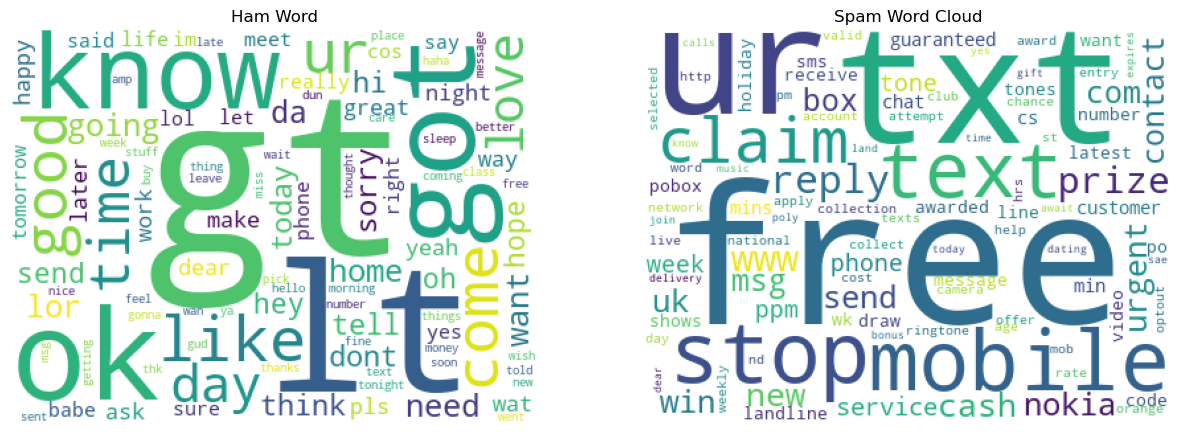

In [165]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
plt.title('Ham Word')
count_dic = dict(zip(count_ham['word'], count_ham['count']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,2,2)
plt.title('Spam Word Cloud')
count_dic = dict(zip(count_spam['word'], count_spam['count']))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)


plt.show

위의 wordcloud를 살펴보면 왼쪽의 정상 메일에서는 gt, lt, got, ok 순으로 빈도수가 높음을 알 수 있고 스팸 메일에서는 free, txt ur, stop 순으로 빈도수가 높음을 확인할 수 있다.